In [2]:
cd ..


d:\online class\DeepLearning\Object Detection


d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pwd

'd:\\online class\\DeepLearning\\Object Detection'

In [67]:
## Python in-built tools 
import os
import pickle
from tqdm import tqdm

## Data Science Tools 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline
import torch
import torch.nn as nn

## Image Processing Tools 
import cv2
import selectivesearch
from torch.utils.data import Dataset, DataLoader 


## Frameworks
from torchvision import transforms
from torchvision import models
from torchsummary import summary
from torchvision.ops import nms


Hyper Parameters

In [5]:
image_paths = "data/images/images"
csv_path = "data/df.csv"
batch_size = 2
n_epochs = 5
learning_rate = 1e-4
threshold_iou = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# open image datasets loading

In [7]:
class OpenImageDataset(Dataset):

    def __init__(self, image_paths, csv_path):
        super().__init__()
        self.image_paths = image_paths
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.unique_images = self.df['ImageID'].unique()

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_full_path = os.path.join(os.getcwd(), self.image_paths, image_id + ".jpg")
        image = cv2.imread(image_full_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h, w, _ = image.shape
        df = self.df.loc[self.df['ImageID'] == image_id]

        bboxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        bboxes = (bboxes * np.array([w, h, w, h])).astype(np.uint16)

        classes = df['LabelName'].values
        return image, bboxes, classes, image_full_path

datasets = OpenImageDataset(image_paths, csv_path)
#datasets[]

In [8]:
len(datasets)

15225

<function matplotlib.pyplot.show(close=None, block=None)>

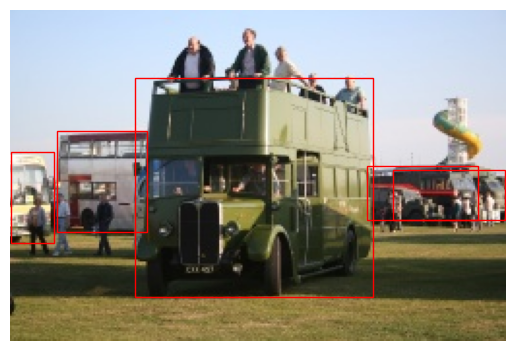

In [9]:
img, bbx, _, _ = datasets[14]
plt.imshow(img)
plt.axis('off')

for bb in bbx:
    rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1], edgecolor = 'r', facecolor = 'none', linewidth = 1)
    plt.gca().add_patch(rect)
plt.show


### Utils Function

In [10]:
def extract_candidates(img):
    _, regions = selectivesearch.selective_search(img, scale=4, min_size=20)
    candidates = []
    img_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        if region['size'] < 0.05*img_area:
            continue
        if region['size'] > img_area:
            continue 
        candidates.append(region['rect'])
    return candidates

def extract_iou(bbox1, bbox2, epsilon=1e-5):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    width = x2 - x1
    height = y2 - y1

    if width < 0 or height < 0:
        return 0
    
    intersection_area = width * height 
    area_1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = area_1 + area_2 - intersection_area
    return intersection_area / (union_area + epsilon)


In [36]:
# FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
# # N = 100
# for i, (image, bboxes, classes, image_full_path) in enumerate(datasets):
#     # if i == N:
#     #     break

#     H, W, _ = image.shape
#     candidates = extract_candidates(image)
#     candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

#     clss, deltas, rois = [], [], []
#     ious = np.array([[extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
    
#     for j, candidate in enumerate (candidates):
#         cx, cy, cX, cY = candidate
#         candidate_ious = ious[j]
#         best_iou_at = np.argmax(candidate_ious)
#         best_iou = candidate_ious[best_iou_at]
#         best_bb = _x, _y, _X, _Y = bboxes[best_iou_at]

#         if best_iou > threshold_iou:
#             clss.append(classes[best_iou_at])
#         else:
#             clss.append('background')

#         delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
#         deltas.append(delta)

#         rois.append(candidate / np.array([W, H, W, H]))

#     FULL_PATHS.append(image_full_path)
#     GTBBS.append(bboxes)
#     CLSS.append(clss)
#     DELTAS.append(deltas)
#     ROIS.append(rois)
#     IOUS.append(ious)


#### multiprocessing mathi ko satta tala ko 2 ota section garyo vani mathi 4 hour ko kam 1 hour ma huncha

In [37]:
# def extract_all(t):
#     image, bboxes, classes, image_full_path = t
#     H, W, _ = image.shape
#     candidates = extract_candidates(image)
#     candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
#     clss, deltas, rois = [], [], []
#     ious = np.array([extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
#     for j, candidate in enumerate(candidates):
#         cx, cy, CX, CY = candidate
#         candidate_ious = ious[j]
#         best_iou_at = np.argmax(candidate_ious)
#         best_iou = candidate_ious[best_iou_at]
#         best_bb = (_x, _y, _X, _Y) = bboxes[best_iou_at]
        
#         if best_iou > threshold_iou:
#             clss.append(classes[best_iou_at])
#         else:
#             clss.append('background')
        
#         delta = np.array([_x - cx, _y - cy, _X - CX, _Y - CY]) / np.array([W, H, W, H])
#         deltas.append(delta)
#         rois.append(candidate / np.array([W, H, W, H]))
    
#     return image_full_path, bboxes, clss, deltas, rois, ious


In [38]:
# from multiprocessing import Pool
# FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

# with Pool(14) as p:
#     results = p.imap(extract_all, datasets)
#     for result in tqdm(results):
#         image_full_path, bboxes, clss, deltas, rois, ious = result
#         FULL_PATHS.append(image_full_path)
#         GTBBS.append(bboxes)
#         CLSS.append(clss)
#         DELTAS.append(deltas)
#         ROIS.append(rois)
#         IOUS.append(ious)


### Pickle Utils Function

### Datasets for R-CNN

In [12]:
FULL_PATHS = load_pickle('full_paths.pkl')
GTBBS = load_pickle('gtbbs.pkl')
CLSS = load_pickle('clss.pkl')
DELTAS = load_pickle('deltas.pkl')
ROIS = load_pickle('rois.pkl')
IOUS = load_pickle('ious.pkl')

In [13]:
unique_labels = np.unique(np.array([c for clss in CLSS for c in clss])) # 2d data lai 1d ma lerayera unique label nikaleko
target2label = {i:label for i, label in enumerate(unique_labels)}
label2target = {label:i for i, label in enumerate(unique_labels)}

print(target2label)
print(label2target)
background_class = label2target['background']
print(background_class)

{0: 'Bus', 1: 'Truck', 2: 'background'}
{'Bus': 0, 'Truck': 1, 'background': 2}
2


In [14]:
len(FULL_PATHS)

15225

In [43]:
# # sir ko code but error ayo

# def preprocess(crop_img):
#     crop_img = torch.tensor(crop_img).permute(2, 0, 1)
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     crop_img = normalize(crop_img)
#     return crop_img.float()


# class RCNNDataset(Dataset):
#     def __init__(self, fpaths, rois, gtbbs, labels, deltas, ious):
#         super().__init__()
#         self.fpaths = fpaths
#         self.rois = rois
#         self.gtbbs = gtbbs
#         self.labels = labels
#         self.deltas = deltas
#         self.ious = ious
#         self.label2target = {'background':0, 'bus':1}

#     def __len__(self):
#         return len(self.fpaths)

#     def __getitem__(self, index):
#         fpath = self.fpaths[index]
#         image = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
#         H, W, _ = image.shape
        
#         gtbbs = self.gtbbs[index]
        
#         rois = self.rois[index]
#         bbs = (rois * np.array([W, H, W, H])).astype(np.uint8)
        
#         crops = [image[y:Y ,x:X] for x, y, X, Y in bbs]
#         labels = self.labels[index]
#         deltas = self.deltas[index]
#         fpath = self.fpaths[index]
        
#         return image, gtbbs, bbs ,crops , labels, deltas, fpath

        
#     def collate_fn(self, batch):
#         inputs, output_labels, output_deltas = [], [], []
#         for i in range(len(batch)):
#             image, gtbbs, bbs, crops, labels, deltas, fpath = batch[i]
#             crops = [cv2.resize(crop, (224, 224)) for crop in crops]
#             crops = [preprocess(crop/255.0)[None] for crop in crops]
#             inputs.extend(crops)
#             output_labels.extend([label2target[label] for label in labels])
#             output_deltas.extend(deltas)
            
#     # yo tala ko 3 ota line le garda train garna lai feasible banako ho
#         inputs = torch.cat(inputs).to(device)
#         output_labels = torch.tensor(output_labels).long().to(device)
#         output_deltas = torch.tensor(output_deltas).float().to(device)
        
#         return inputs, output_labels, output_deltas

            
            
# # [] = [1,2,4] + [6, 7, 8]-> extend -> [1,2,4, 6, 7, 8]
# # [] = [1,2,4] -> append -> [[1,2,4]]

#         # Further processing (not defined yet)
#         # You can add more code to preprocess inputs and handle labels, deltas, etc.

# # n_train = len(FULL_PATHS) * 8//10

# dataset = RCNNDataset(FULL_PATHS, GTBBS, CLSS, DELTAS , ROIS, IOUS)
# # len(dataset)
# dataset.collate_fn([dataset[10], dataset[11]])

In [15]:
def preprocess(crop_img):
    crop_img = torch.tensor(crop_img).permute(2, 0, 1)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    crop_img = normalize(crop_img)
    return crop_img.float()


class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, gtbbs, labels, deltas, ious):
        super().__init__()
        self.fpaths = fpaths
        self.rois = rois
        self.gtbbs = gtbbs
        self.labels = labels
        self.deltas = deltas
        self.ious = ious
        self.label2target = {'background': 0, 'bus': 1}

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index):
        fpath = self.fpaths[index]
        image = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]  # Convert BGR to RGB
        H, W, _ = image.shape

        gtbbs = self.gtbbs[index]

        rois = self.rois[index]
        bbs = (rois * np.array([W, H, W, H])).astype(np.uint8)  # Convert bounding boxes to integers

        # bbs is required because the Selective Search algorithm may return bounding boxes outside the image
        bbs = np.clip(bbs, 0, [W, H, W, H])

        # Get crops and check if valid
        # crops = []
        # for x, y, X, Y in bbs:
        #     if X > x and Y > y:  # Ensure bounding box has a valid area
        #         crop = image[y:Y, x:X]
        #         if crop.size > 0:  # Ensure the crop is not empty
        #             crops.append(crop)
        
        crops = [image[y:Y, x:X] for x, y, X, Y in bbs]
        labels = self.labels[index]
        deltas = self.deltas[index]
        
        return image, gtbbs, bbs, crops, labels, deltas, fpath

    def collate_fn(self, batch):
        inputs, output_labels, output_deltas = [], [], []
        for i in range(len(batch)):
            image, gtbbs, bbs, crops, labels, deltas, fpath = batch[i]
            
            # Resize valid crops and preprocess them
            crops = [cv2.resize(crop,(224, 224)) for crop in crops ]
            crops = [preprocess(crop/255.0)[None] for crop in crops]
            
            inputs.extend(crops)
            output_labels.extend([label2target[label] for label in labels])
            output_deltas.extend(deltas)

    # yo tala ko 3 ota line le garda train garna lai feasible banako ho
        inputs = torch.cat(inputs).to(device)
        output_labels = torch.tensor(output_labels).long().to(device)
        output_deltas = torch.tensor(output_deltas).float().to(device)

        return inputs, output_labels, output_deltas


# [] = [1,2,4] + [6, 7, 8]-> extend -> [1,2,4, 6, 7, 8]
# [] = [1,2,4] -> append -> [[1,2,4]]

        # Further processing (not defined yet)
        # You can add more code to preprocess inputs and handle labels, deltas, etc.

n_train = len(FULL_PATHS) * 8//10
train_dataset = RCNNDataset(FULL_PATHS[:n_train], ROIS[:n_train], GTBBS[:n_train], CLSS[:n_train], DELTAS[:n_train], IOUS[:n_train])
test_dataset = RCNNDataset(FULL_PATHS[n_train:], ROIS[n_train:], GTBBS[n_train:], CLSS[n_train:], DELTAS[n_train:], IOUS[n_train:])


# Dataloader

In [16]:
# Initialize DataLoader for the training and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn)


## Model architecture

In [17]:
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
backbone.fc = nn.Sequential()

for param in backbone.parameters():
    param.requires_grad = False
backbone.to(device=device) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
summary(backbone.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
class RCNN(nn.Module):
    def __init__(self, backbone, n_classes):
        super().__init__()
        self.backbone = backbone
        self.n_classes = n_classes
        
        self.classification_head = nn.Linear(2048,n_classes)

        self.bbox_localization_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4),
            nn.Tanh()
        )
        
        
        
        self.classification_loss = nn.CrossEntropyLoss()
        self.localization_loss = nn.L1Loss()
        
        self.lmbda = 10.0 #priotizes localization loss over classification loss
        
        
        
    def forward(self, inputs):
        feat = self.backbone(inputs)
        
        cls_score = self.classification_head(feat)
        
        deltas = self.bbox_localization_head(feat)
        
        return cls_score, deltas
    
    
    def calculate_loss(self, _labels, _deltas, actual_labels, actual_deltas):
        
        #classification loss   
        classification_loss = self.classification_loss(_labels, actual_labels)
        
        #localization loss
        ix = torch.where(actual_labels != background_class)[0]
        _deltas = _deltas[ix]
        actual_deltas = actual_deltas[ix]
        
        if (len(ix)>0):
            localization_loss = self.localization_loss(_deltas, actual_deltas)
        else:
            localization_loss = torch.tensor(0)
            
        total_loss = classification_loss + self.lmbda * localization_loss
        
        return total_loss, classification_loss, localization_loss
            
        
# inputs, _ , targets_deltas = next(iter(train_dataloader))
# rcnn = RCNN(backbone=backbone, n_classes=len(unique_labels)).to(device=device)
# rcnn(inputs)

In [50]:
# Loss Function
# Train Batch
# validate batch
#validate batch
#test prediction

In [21]:
def train_batch(model, optimizer, inputs, actual_labels, deltas):
    model.train()
    optimizer.zero_grad()

    # forward pass
    _labels, _deltas = model(inputs)
    total_loss, classification_loss, localization_loss = model.calculate_loss(_labels, _deltas, actual_labels, deltas)
    conf, pred_labels = _labels.max(-1)
    acc = pred_labels == actual_labels

    # backward pass
    total_loss.backward()
    optimizer.step()

    return _labels, _deltas, total_loss, classification_loss, localization_loss, acc


In [22]:
@torch.no_grad
def validate_batch(model, inputs, actual_labels, deltas):
    model.eval()
    _labels, _deltas = model(inputs)
    total_loss, classification_loss, localization_loss = model.calculate_loss(_labels, _deltas, actual_labels, deltas)

    conf, pred_labels = _labels.max(-1)
    acc = pred_labels == actual_labels

    return _labels, _deltas, total_loss, classification_loss, localization_loss, acc


In [23]:
rcnn = RCNN(backbone, 3).to(device=device)
optimizer = torch.optim.SGD(rcnn.parameters(), lr=learning_rate)
background_class = label2target['background']

In [54]:
# training pipeline

train_history = {
    'total_loss': [],
    'detection_loss': [],
    'localization_loss': [],
    'accuracy': []
}

test_history = {
    'total_loss': [],
    'detection_loss': [],
    'localization_loss': [],
    'accuracy': []
}

for epoch in range(1, n_epochs + 1):
    epoch_train_total_loss = 0
    epoch_train_detection_loss = 0
    epoch_train_localization_loss = 0
    epoch_train_acc = []

    for inputs, labels, deltas in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epochs}'):
        _inputs ,_deltas, total_loss , classification_loss, localization_loss, acc = train_batch(rcnn,optimizer, inputs, labels, deltas)
        epoch_train_total_loss += total_loss.item()
        epoch_train_detection_loss += classification_loss.item()
        epoch_train_localization_loss += localization_loss.item()
        epoch_train_acc.extend(acc.tolist())
        
    epoch_train_total_loss /= len(train_dataloader)
    epoch_train_detection_loss /= len(train_dataloader)
    epoch_train_localization_loss /= len(train_dataloader)
    epoch_train_acc = sum(epoch_train_acc)  / len(epoch_train_acc)
        
    epoch_test_total_loss = 0
    epoch_test_detection_loss = 0
    epoch_test_localization_loss = 0
    epoch_test_acc = []

    for inputs, labels, deltas in tqdm(test_dataloader, desc=f'Testing '):
        _inputs ,_deltas, total_loss ,classification_loss, localization_loss, acc = validate_batch(rcnn, inputs, labels, deltas)
        epoch_test_total_loss += total_loss.item()
        epoch_test_detection_loss += classification_loss.item()
        epoch_test_localization_loss += localization_loss.item()
        epoch_test_acc.extend(acc.tolist())
        
    epoch_test_total_loss /= len(test_dataloader)   
    epoch_test_detection_loss /= len(test_dataloader)
    epoch_test_localization_loss /= len(test_dataloader)
    epoch_test_acc = sum(epoch_test_acc) / len(test_dataloader)

    train_history.get('total_loss').append(epoch_train_total_loss)
    train_history.get('detection_loss').append(epoch_train_detection_loss)
    train_history.get('localization_loss').append(epoch_train_localization_loss)
    train_history.get('accuracy').append(epoch_train_acc)
    
    test_history.get('total_loss').append(epoch_test_total_loss)
    test_history.get('detection_loss').append(epoch_test_detection_loss)
    test_history.get('localization_loss').append(epoch_test_localization_loss)
    test_history.get('accuracy').append(epoch_test_acc)
    
    print(f'Epoch {epoch} of {n_epochs}, Training_loss: {epoch_train_total_loss}, Testing Detection Loss: {epoch_test_total_loss}, Testing Localization Loss: {epoch_test_localization_loss}, Testing Accuracy: {epoch_test_acc}')

Testing : 100%|██████████| 1523/1523 [13:39<00:00,  1.86it/s]


Epoch 1 of 5, Training_loss: 1.2394308617818728, Testing Detection Loss: 1.1327938968444136, Testing Localization Loss: 0.06743691177966558, Testing Accuracy: 46.02495075508864


Training 2 of 5:  39%|███▉      | 2361/6090 [24:22<38:29,  1.61it/s]  


KeyboardInterrupt: 

In [ ]:
torch.tensor(100).item()

# model use garera bounding box nikaleko

In [ ]:
# def read_and_preprocess_image(image_path):

#     image = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
#     H, W, _ = image.shape
#     candidates = extract_candidates(image)
#     candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
#     inputs = []
#     for x, y, X, Y in candidates:
#         crop = cv2.resize(image[y:Y, x:X], (224, 224))
#         inputs.append(preprocess(crop / 255.0)[None])
#     return image, torch.cat(inputs).to(device), candidates, H, W


# def predict(inputs):
#     with torch.no_grad():
#         rcnn.eval()
#         labels, deltas = rcnn(inputs)
#         probs = torch.nn.functional.softmax(labels,-1)
#         conf, clss = probs.max(-1)
#     return conf, clss, probs, deltas 

# def post_processing(conf, clss, probs, deltas, candidates, H, W):
#     conf, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [conf, clss, probs, deltas]]     
#     # remove background classes and slelection of non backgorund classes only
#     indexes = clss != background_class
#     conf, clss, probs, deltas, candidates = [tensor[indexes] for tensor in [conf, clss, probs, deltas, candidates]]
    
#     bboxes = (deltas * np.array([W, H, W ,H])) + candidates
#     bboxes.astype (np.uint16)
    
#     ix = nms(torch.tensor(bboxes.astype(np.float32)), torch.tensor(conf), iou_threshold=0.5)
#     float32: type[floating[_32Bit]]
#     return [tensor[ix] for tensor in [conf, clss, probs, deltas, candidates, bboxes]]
    


# def test_prediction(image_path, display=True):
#     # imagae preprocessing and make ready for inputs in model
#     image, inputs, candidates, H, W = read_and_preprocess_image(image_path)
    
#     # image = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
#     # H, W, _ = image.shape
#     # candidates = extract_candidates(image)
#     # candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
#     # inputs = []
#     # for x, y, X, Y in candidates:
#     #     crop = cv2.resize(image[y:Y, x:X], (224, 224))
#     #     inputs.append(preprocess(crop / 255.0)[None])
#     # inputs = torch.cat(inputs).to(device)

#     # pass candidates to rcnn model
    
#     conf,clss, probs, deltas = predict(inputs)
    
#     conf, clss, probs, deltas, candidates, bboxes = post_processing(conf, clss, probs, deltas, candidates, H, W)
#     # with torch.no_grad():
#     #     rcnn.eval()
#     #     labels, deltas = rcnn(inputs)
#     #     probs = torch.nn.functional.softmax(labels,-1)
#     #     conf, clss = probs.max(-1)
#     # conf,clss, probs,deltas , candidates, bboxes = post_processing(conf, clss, probs, deltas, candidates, H, W)    
            
        
        
        
        
#       ##############################################
#       ###### POST PROCESSING ########
#       ##############################################
      
#     # conf, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [conf, clss, probs, deltas]]     
#     # # remove background classes and slelection of non backgorund classes only
#     # indexes = clss != background_class
#     # conf, clss, probs, deltas, candidates = [tensor[indexes] for tensor in [conf, clss, probs, deltas, candidates]]
    
#     # bboxes = (deltas * np.array([W, H, W ,H])) * candidates
#     # bboxes.astype (np.uint16)
    
#     # ix = nms(torch.tensor(bboxes.astype(np.float32)), torch.tensor(conf), iou_threshold=0.5)
#     # float32: type[floating[_32Bit]]
#     # conf, clss, probs, deltas, candidates = [tensor[ix] for tensor in [conf, clss, probs, deltas, candidates]]

#     if display:
#         fig,ax = plt.subplots(1,2,figsize=(20,10))
#         ax[0].imshow(image)
#         ax[0].axis('off')
#         ax[0].grid(False)
#         ax[0].set_title('Original Image')
    
#         # if len(conf)==0:
#         #     ax[1].imshow(image)
#         #     ax[1].axis('off')
#         #     ax[1].grid(False)
#         #     ax[1].set_title('Original Image with No bounding box')
        
#         # else:  
#         ax[1].imshow(image)
#         ax[1].axis('off')
#         ax[1].grid(False)
#         ax[1].set_title('Original Image with bounding box')

#         for bb,cls in zip(bboxes,clss):
#             color = {0:'b', 1:'r', 2:'g'}
#             rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1],linewidth=2,  edgecolor=color.get(cls),  facecolor='none')
#             ax[1].add_patch(rect)
#         plt.show()
        
        
#     # return conf,clss, bboxes
    
# test_prediction('test.jpg')


# Same mathi ko ho tara class use garera call garna milayera sajilai use garna milcha

In [95]:
class InferenceRCNN:
    def __init__(self, model, device, background_class, preprocess, nms, extract_candidates):
        self.rcnn = model
        self.device = device
        self.background_class = background_class
        self.preprocess_fn = preprocess
        self.nms_fn = nms
        self.extract_candidates_fn = extract_candidates
    
    def preprocess(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
        H, W, _ = image.shape
        candidates = self.extract_candidates_fn(image)
        candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates])
        inputs = []
        for x, y, X, Y in candidates:
            crop = cv2.resize(image[y:Y, x:X], (224, 224))
            inputs.append(self.preprocess_fn(crop / 255.0)[None])
        return image, torch.cat(inputs).to(self.device), candidates, H, W

    def forward(self, inputs):
        with torch.no_grad():
            self.rcnn.eval()
            labels, deltas = self.rcnn(inputs)
            probs = torch.nn.functional.softmax(labels, -1)
            conf, clss = probs.max(-1)
        return conf, clss, probs, deltas

    def post_process(self, conf, clss, probs, deltas, candidates, H, W):
        conf, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [conf, clss, probs, deltas]]
        # Filter out background classes
        indexes = clss != self.background_class
        conf, clss, probs, deltas, candidates = [tensor[indexes] for tensor in [conf, clss, probs, deltas, candidates]]
        # Adjust bounding boxes
        bboxes = (deltas * np.array([W, H, W, H])) + candidates
        bboxes = bboxes.astype(np.uint16)
        # Perform non-maximum suppression (NMS)
        ix = self.nms_fn(torch.tensor(bboxes.astype(np.float32)), torch.tensor(conf), iou_threshold=0.5)
        return [tensor[ix] for tensor in [conf, clss, probs, deltas, candidates, bboxes]]

    def display(self, image, bboxes, clss):
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].grid(False)
        ax[0].set_title('Original Image')

        ax[1].imshow(image)
        ax[1].axis('off')
        ax[1].grid(False)
        ax[1].set_title('Image with Bounding Box')

        color_map = {0: 'b', 1: 'r', 2: 'g'}
        for bb, cls in zip(bboxes, clss):
            rect = patches.Rectangle(bb[:2], bb[2] - bb[0], bb[3] - bb[1], linewidth=2, 
                                     edgecolor=color_map.get(cls, 'y'), facecolor='none')
            ax[1].add_patch(rect)

        plt.show()

    def __call__(self, image_path, display=True):
        # Preprocess the image
        image, inputs, candidates, H, W = self.preprocess(image_path)
        # Forward pass to get predictions
        conf, clss, probs, deltas = self.forward(inputs)
        # Post-process to refine predictions and filter
        conf, clss, probs, deltas, candidates, bboxes = self.post_process(conf, clss, probs, deltas, candidates, H, W)
        # Optionally display results
        if display:
            self.display(image, bboxes, clss)


### mathi ko class call garne process

C:\Users\uniqu\AppData\Local\Temp\ipykernel_49560\468890336.py:61: RuntimeWarning: overflow encountered in scalar subtract
  rect = patches.Rectangle(bb[:2], bb[2] - bb[0], bb[3] - bb[1], linewidth=2,
d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\matplotlib\patches.py:786: RuntimeWarning: overflow encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)


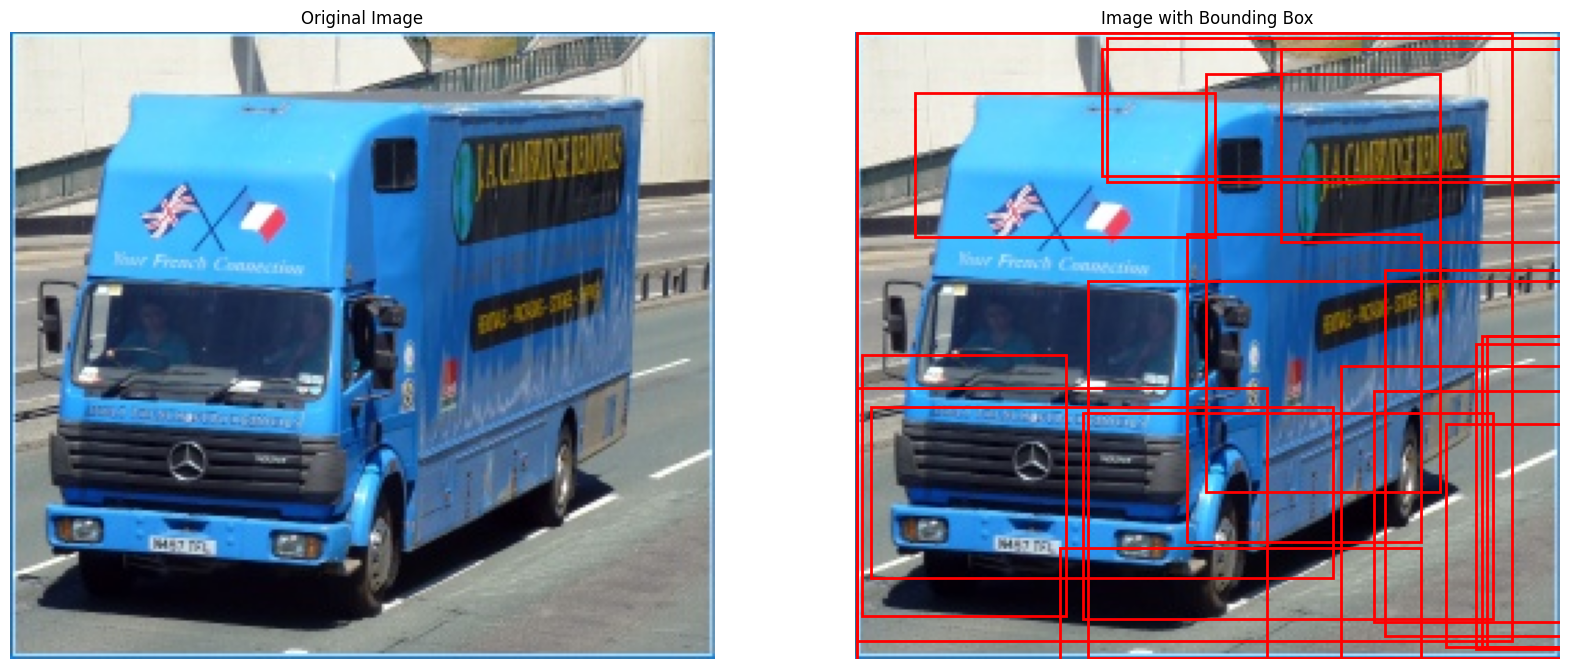

In [105]:
inference = InferenceRCNN(rcnn, device, background_class, preprocess, nms, extract_candidates)
inference('test.jpg', display=True)


### custom model.pth use garera inference nikaleko bounding box ko 

C:\Users\uniqu\AppData\Local\Temp\ipykernel_49560\2160471549.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load('model.pth', map_location=device)


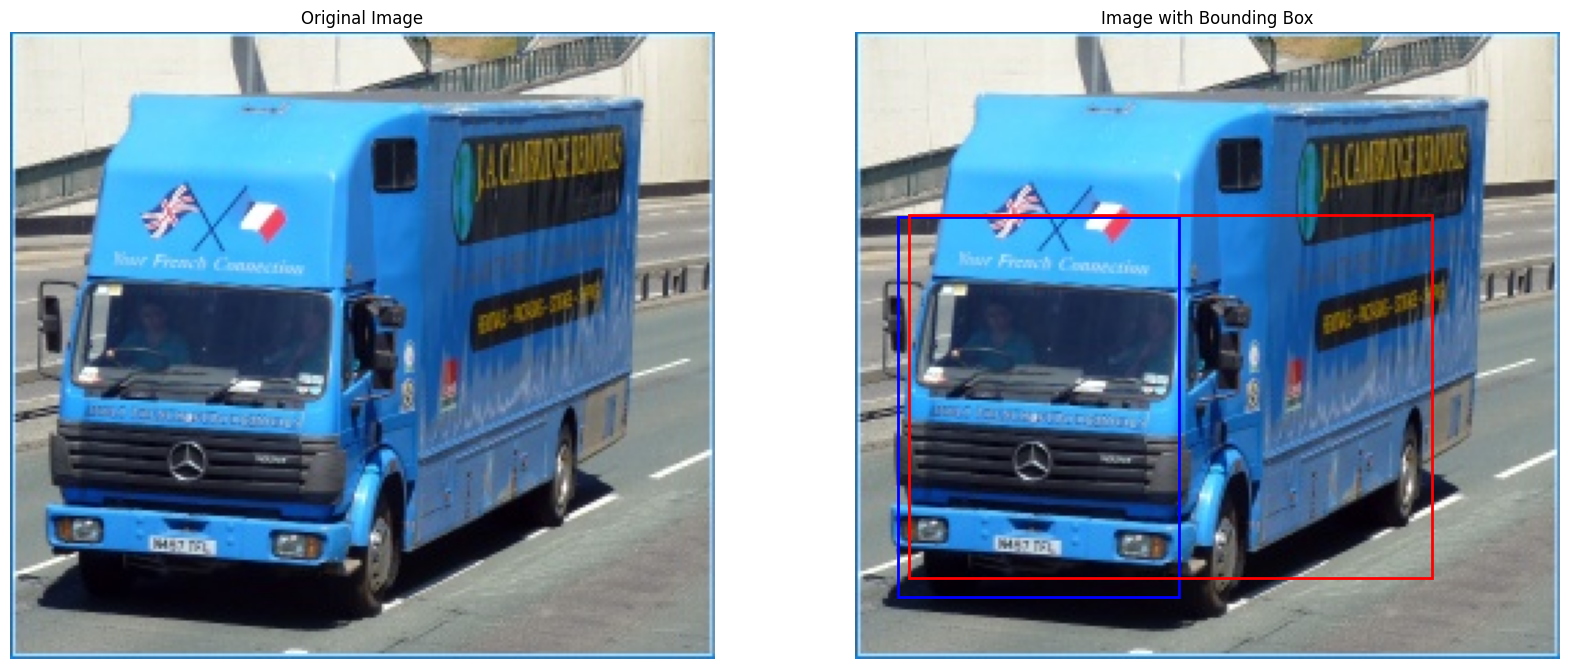

In [106]:
test = torch.load('model.pth', map_location=device)
test.eval()
inference = InferenceRCNN(test, device, background_class, preprocess, nms, extract_candidates)
inference('test.jpg', display=True)